In [2]:
# Importing dependencies
import numpy as np
import pandas as pd
#from math import pi, sqrt
from os import path, listdir

## Load data:

In [3]:
# Data directories:
exoplanets_dir = path.expanduser("~/OneDrive/SEPHI_data/exoplanets/")
phase_space_dir = path.expanduser("~/OneDrive/phase_space_density_data/classification/dr3/")
# The first file is features_densities_gaiaedr3_6d_0_200000.csv
# The next file is 400,000
# Goes up in incraments of 200,000

# The date that the exoplanets data (NASA EA) was downloaded:
data_date = "2022_04_28"

In [4]:
# Load exoplanets data:
exoplanets = pd.read_csv(path.join(exoplanets_dir, f"exoplanets_" + data_date + f".csv"))

In [5]:
def load_data(data_dir):
    """
    Takes in a data directory and sorts out which files contain 5d and 6d 
    information. Returns two lists of file names, 5d and 6d.
    """
    #list_5d = []
    list_6d = []
    for file in sorted(listdir(data_dir)):
        if "apg" in file:
            continue
        df = pd.read_csv(path.join(data_dir, file), index_col=0)    
        if "6d" in file:
            list_6d.append(df)
        df = pd.read_csv(path.join(data_dir, file), index_col=0)
        #elif "5d" in file:
            #list_5d.append(df)
                
    # TODO: what does concat do?
    #df_5d = pd.concat(list_5d, axis=0, ignore_index=True)
    df_6d = pd.concat(list_6d, axis=0, ignore_index=True)
    return df_6d
    #return df_5d, df_6d

In [6]:
df_6d = load_data( phase_space_dir )
#df_5d, df_6d = load_data( phase_space_dir )

new_cols = {"Host":"gaia_source_id", 
            "target_density":"psd", 
            "class":"class_6d", 
            "gm_p_low":"gm_p_low_6d", 
            "gm_p_high":"gm_p_high_6d", 
            "class":"class_6d"}

df_6d.rename(columns=new_cols, inplace=True)
# TODO: whyy, is it telling me the directory etc??

# I'm only using the 6d phase-space density reults for now, but if I wanted to 
#merge the 5d and 6d data frames, I would run the following:
#df = pd.merge(df_5d, df_6d[["Host", "class_6d", "gm_p_high_6d"]], on="Host")

# Crossmatch with the exoplanets data

In [12]:
# Check for repeated gaia ids in df_6D
duplicates = df_6d.duplicated(subset="gaia_source_id", keep='first')
i = np.where(duplicates == True)
print(i)
# There are no duplicated gaia ids in df_6D

(array([], dtype=int64),)


In [13]:
# Columns I am interested in:
# host i.e. gaia ID
# psd = phase space density
# gp_p_low_6d
# gm_p_high_6d
# psd_class (phase space density class)

exoplanets = pd.merge(exoplanets, df_6d[["gaia_source_id", "psd", "gm_p_low_6d", "gm_p_high_6d", "class_6d"]], on="gaia_source_id", how="left", indicator="EXOorPSD", validate="many_to_many")
#validate="many_to_one"
# TODO:
# error: Merge keys are not unique in right dataset; not a many-to-one merge

In [14]:
matched_psd = np.where(exoplanets["EXOorPSD"] == "both")
print("Planets in exoplanets were matched with", matched_psd[0].size, "stellar phase-space-densities.")

Planets in exoplanets were matched with 1639 stellar phase-space-densities.


# Saving the data:

In [15]:
exoplanets.to_csv( path.join( exoplanets_dir, f"exoplanets_psd_" + data_date + f".csv"), index=False )

# Reproducing W20 plots:

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
# TODO: plot log(planet mass [Earth mass]) vs log(semi-major axis [AU])
# for low and high phase space density
# Classifications:
# 0 = low
# 1 = ambiguous
# 2 = high
print(exoplanets["class_6d"])
# Indicies of low and high phase-space density planets:
low_index = np.where(exoplanets["class_6d"] == 0. )
high_index = np.where(exoplanets["class_6d"] == 2.)

0       0.0
1       2.0
2       0.0
3       2.0
4       2.0
       ... 
5009    NaN
5010    NaN
5011    NaN
5012    NaN
5013    NaN
Name: class_6d, Length: 5014, dtype: float64


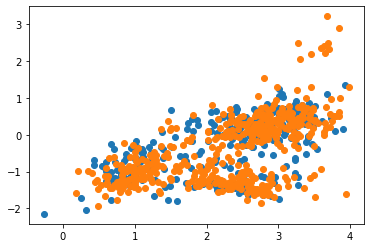

In [25]:
plt.scatter( np.log10(exoplanets["NEA_pl_bmasse"].iloc[low_index]), np.log10(exoplanets["NEA_pl_sma"].iloc[low_index]) )
plt.scatter( np.log10(exoplanets["NEA_pl_bmasse"].iloc[high_index]), np.log10(exoplanets["NEA_pl_sma"].iloc[high_index]) )

Text(0.02, 0.5, 'log(M_p [M_E])')

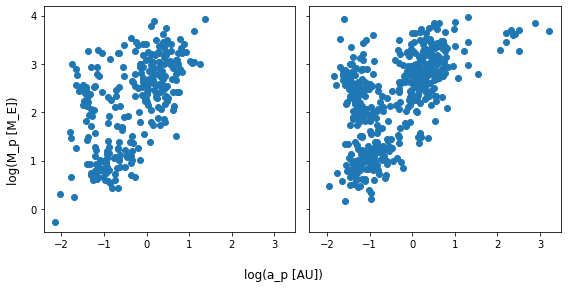

In [55]:
fig, (ax_l, ax_h) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=[8,4], tight_layout=True)

ax_l.scatter( np.log10(exoplanets["NEA_pl_sma"].iloc[low_index]), np.log10(exoplanets["NEA_pl_bmasse"].iloc[low_index]) )
ax_h.scatter( np.log10(exoplanets["NEA_pl_sma"].iloc[high_index]), np.log10(exoplanets["NEA_pl_bmasse"].iloc[high_index]) )
# sharex makes them share the x-axis scale

fig.supxlabel('log(a_p [AU])')
fig.supylabel('log(M_p [M_E])')


In [16]:
print(exoplanets.head())

      pl_name  hostname              gaia_designation  sy_snum  sy_pnum  \
0    11 Com b    11 Com  Gaia DR2 3946945413106333696        2        1   
1    11 UMi b    11 UMi  Gaia DR2 1696798367260229376        1        1   
2    14 And b    14 And  Gaia DR2 1920113512486282240        1        1   
3    14 Her b    14 Her  Gaia DR2 1385293808145621504        1        2   
4  16 Cyg B b  16 Cyg B  Gaia DR2 2135550755683407232        3        1   

   discoverymethod  NEA_pl_orbper  NEA_pl_sma  NEA_pl_rade  NEA_pl_bmasse  \
0  Radial Velocity      326.03000        1.29          NaN      6165.6000   
1  Radial Velocity      516.21997        1.53          NaN      4684.8142   
2  Radial Velocity      185.84000        0.83          NaN      1525.5000   
3  Radial Velocity     1773.40002        2.93          NaN      1481.0878   
4  Radial Velocity      798.50000        1.66          NaN       565.7374   

   ...  CKSII_pl_raderr2  CKSII_pl_sma  CKSII_pl_smaerr1  CKSII_pl_smaerr2  \
0  ...  